# アニメーション動画の作成

## 連番画像の作成

連番の画像を作ることで，それらを結合した動画を作成することができます．本家GMTではシェルスクリプトによるループを自力で作成するほか，`gmt movie` という[モジュール](https://docs.generic-mapping-tools.org/latest/movie.html) があります．PyGMTへの`gmt movie`モジュールの移植はv0.9.0時点でまだ実現していないようでが，Pythonのループを使えば，簡単に連番画像を作成することができます．

ここでは，1枚の画像を作る関数を `for` ループでパラメタを変えながら実行して画像保存する方法を一例として紹介します．

In [2]:
import pygmt
import numpy as np
import os
import tempfile

まず，画像の作成です．ここでは簡単な三角関数のグラフを，波が伝播しているかのように横に平行移動させていくことにしましょう．

In [3]:
def plot_fig(phi):
    
    """ 初期位相 `phi` の sin カーブを描画する．"""

    x = np.linspace(0, 5, 201)
    y = np.sin(2*np.pi*x + phi)
    
    fig = pygmt.Figure()
    
    fig.plot(region = [0, 5, -1.1, 1.1], projection = 'X10c/4c', 
             x = x, y = y, 
             pen = 'thick,200/110/30', frame = ['WS', 'xaf', 'yaf'])

    return fig

これを単独で実行すると，以下のようになります．`plot_fig()`関数はPyGMTの`fig`オブジェクトを返すため，`.show()`メソッドにより画像を表示させています．

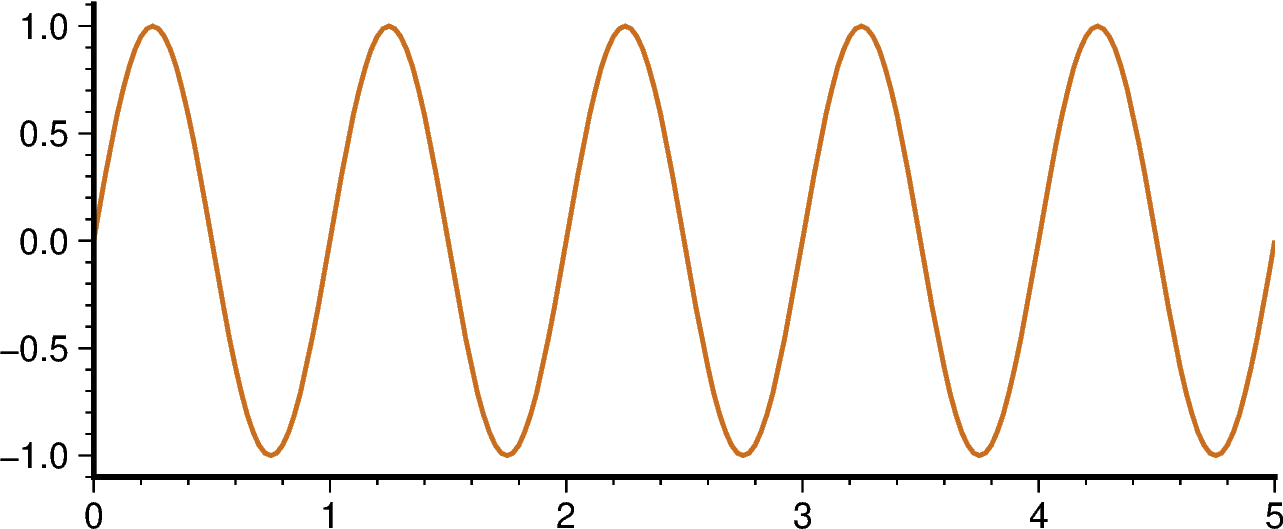

In [4]:
plot_fig(0.0).show() #  0.0の場合

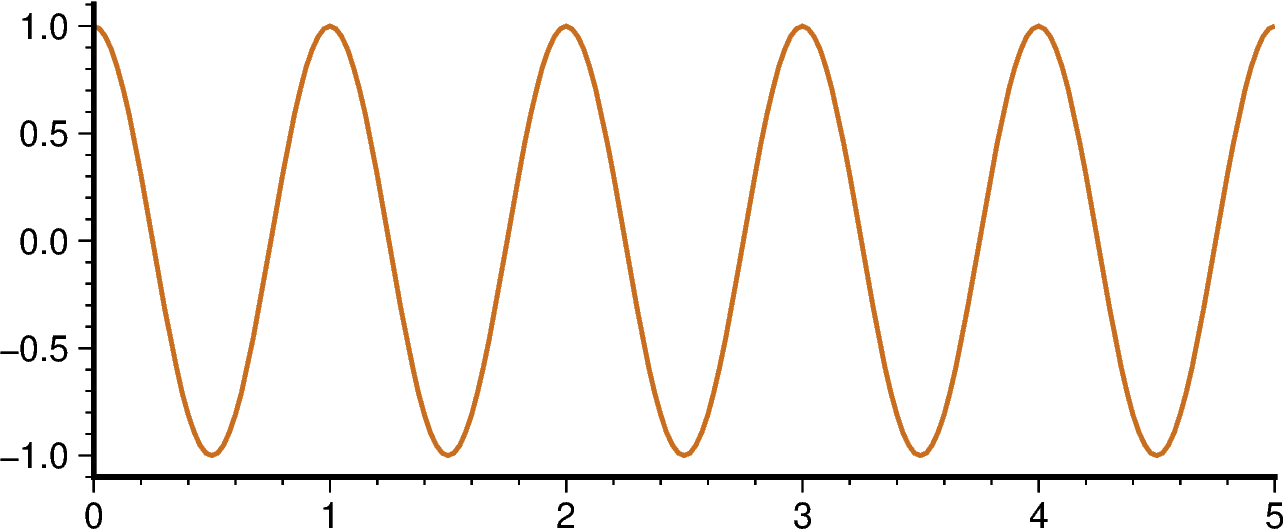

In [5]:
plot_fig(np.pi/2).show() # π/2の場合

たしかに引数の初期位相を変えるとグラフが平行移動している様子がわかります．
それでは，これをループにして少しずつ初期位相を変えつつ，連番のファイルにしていきます．

動画化には `ffmpeg` というツールを使います．このツールで連番ファイルから動画を作る際には，連番の桁数を揃えなければなりません．

In [7]:
# 初期位相のリスト
phi0 = np.arange(0, 2*np.pi, 2*np.pi/200)

# 画像保存先の一時ディレクトリ作成
tmpdir = tempfile.mkdtemp()

# enumerateを使って，初期位相の値＋0からの連番を取り出す．
for i, phi in enumerate(phi0):
    
    f = plot_fig(phi) #画像プロット

    # f文字列を使って連番を3桁整数の文字列に
    figname = f'plot_{i:03d}.png' 
    f.savefig(os.path.join(tmpdir, figname))

CPU times: user 2.73 s, sys: 9.07 s, total: 11.8 s
Wall time: 2min 19s


説明はほぼコメントに書いてあるとおりですが，まず画像を動かすパラメタである初期位相のリストを作り，また同時に画像保存先の一時ディレクトリを作成しておきます．手動でディレクトリ名を指定してもよいのですが，ここでは`tmpfile.mkdtemp()`関数を使いました．この関数は，乱数を使った名前の適当なディレクトリを作成し，そのディレクトリ名を返してくれます．確認してみましょう．

In [12]:
print(tmpdir)

/var/folders/qw/cvrqp2fd6171t6js_gytd9_h0009rj/T/tmplof855wg


In [13]:
! ls $tmpdir

plot_000.png plot_017.png plot_034.png plot_051.png plot_068.png plot_085.png
plot_001.png plot_018.png plot_035.png plot_052.png plot_069.png plot_086.png
plot_002.png plot_019.png plot_036.png plot_053.png plot_070.png plot_087.png
plot_003.png plot_020.png plot_037.png plot_054.png plot_071.png plot_088.png
plot_004.png plot_021.png plot_038.png plot_055.png plot_072.png plot_089.png
plot_005.png plot_022.png plot_039.png plot_056.png plot_073.png plot_090.png
plot_006.png plot_023.png plot_040.png plot_057.png plot_074.png plot_091.png
plot_007.png plot_024.png plot_041.png plot_058.png plot_075.png plot_092.png
plot_008.png plot_025.png plot_042.png plot_059.png plot_076.png plot_093.png
plot_009.png plot_026.png plot_043.png plot_060.png plot_077.png plot_094.png
plot_010.png plot_027.png plot_044.png plot_061.png plot_078.png plot_095.png
plot_011.png plot_028.png plot_045.png plot_062.png plot_079.png plot_096.png
plot_012.png plot_029.png plot_046.png plot_063.png plot_080.png

たしかにディレクトリが作られ，その中に画像が200枚できています．


```{note}
`mkdtemp()`が返すディレクトリの場所は，Pythonやそれを動かすOSによって異なります．自分で設定することもできます．
```

## 動画への変換

作成された画像から動画を作成するには，コマンドラインから `ffmpeg`を使います．ここでは `gif` アニメーションと`mp4` 形式の動画を作成してみましょう．

### gifアニメーション

In [27]:
%%bash -s "$tmpdir" 
ffmpeg -i "$1/plot_%3d.png" \
  -vf "scale=800:-1,split [a][b];[a] palettegen [p];[b][p] paletteuse" \
  -y out.gif \
  > /dev/null 2>&1 

ここでは，いくつかのテクニックを使っています．

まず，Jupyter Notebookの cell magic で，`%%bash`を Pythonセルの最初に記載しておくと，そのセル内は bashのコマンドとして実行される，という機能を使っています．そこに `-s` オプションで，Pythonの `tmpdir` 変数を `"$tmpdir"` として与えました．すると，あたかもこの変数の中身（一時ディレクトリの名前）が，シェルスクリプトの実行時第一引数のように扱われます．つまり，`$1` というシェル変数で利用できるのです．

```{note}
そんな面倒なことをするくらいならUnixコマンドラインで直接ffmpegを実行する，というやりかたもあるでしょう．
```

ffmpeg は `-i` オプションで入力ファイルを，コマンドラインの最後に出力ファイル名を書きます．動画形式は出力ファイル名の拡張子からある程度判断されます．その直前にある`-y`は，出力ファイルがすでにあるときに確認をせずに上書きするためのオプションです．Jupyter Notebook上でbashコマンドを扱うときには，対話的な実行は難しいようなので，このオプションを使っています．

入力と出力の間にある `-vf` からなる行は，出力される画像サイズを指定（`scale=800:-1` で横幅を800pxにしつつ縦横比を維持）するほか，256色しか使えないgifアニメーションを綺麗に出力するためのカラーパレットという機能を用いています．

最終行は`ffmpeg`からの標準エラー出力が大量に出てくるため，それらを捨てるリダイレクションです．

この結果，以下のような動画が作成できました．ちょうどループするように調整して作成したので，延々と波が動いているように見えます．

![](./out.gif)

### Mpeg-4 Movie

一方，`mp4`形式の動画を作成するには，たとえば以下のようにします．

In [14]:
%%bash -s "$tmpdir" 
ffmpeg -i "$1/plot_%3d.png" \
  -vf scale=800:-1 -qscale 0 -pix_fmt yuv420p \
  -y out.mp4 \
  > /dev/null 2>&1

すると，以下のような動画が作成されるはずです．mp4の場合には`-qscale 0` オプションを付けておくとクオリティを劣化させずに動画にできます．

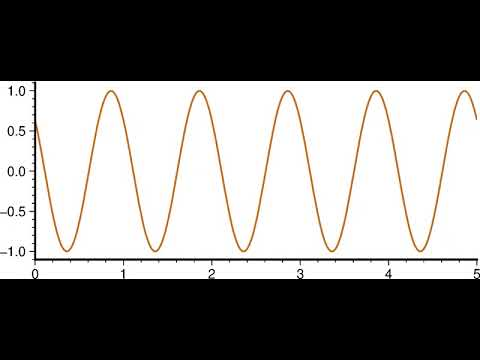

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='rlLIwSc3_YI', width=800, height=400)

````{tip}
ここでは，`tempdir`は作成しっぱなしで，その中身のファイルは削除されません．実際には，このようにシステムの一時ディレクトリ置き場に作られたものは，OSのシステムによって一定期間経つと自動的に削除されるようです．
````

## 大量の画像の効率的な生成

アニメーションを作成するためには，すこしずつ違ったパラメタを用いた大量の画像を作る必要があります．これまでの例ではJupyter Notebookで対話的に実行できる例を紹介してきましたが，図を1枚ずつ作成するのにはどうしても時間がかかります．たとえば，前述の200枚の連番画像を生成するのに，筆者の環境では約140秒かかりました．凝った図のアニメーションを作成しようとすると，図の生成にかかる時間は飛躍的に伸びてしまいます．

そこで，異なる番号の画像を作成するPyGMTプロセスを複数個並列に実行することで，より高速に大量の画像を生成する方法を考えます．

Pytnonには，マルチスレッドで複数の関数を並列に実行する`concurrent`や`threading`といったモジュールもあります．しかし，筆者の環境で試したところ，単一のPythonカーネル内でこれらのライブラリを用いてPyGMTの互いに異なる画像を並列に生成することはできない（文法的に問題なさそうでも実行時エラーが生じる）ようでした．そこで，1枚の画像を生成するPythonスクリプトを，シェル（`bash`など）コマンドを組み合わせることにより複数並列に実行する方針を採ることにします．

まずは，そのためのPythonスクリプトを作成します．作成済みの `plot_fig()` 関数をそのまま使って，以下のようなスクリプトファイル `exe_plot_fig.py` にします．


```python
import sys
import os
import pygmt
import numpy as np


def plot_fig(phi):
    
    """ 初期位相 `phi` の sin カーブを描画する．"""

    x = np.linspace(0, 5, 201)
    y = np.sin(2*np.pi*x + phi)
    
    fig = pygmt.Figure()
    
    fig.plot(region = [0, 5, -1.1, 1.1], projection = 'X10c/4c', 
             x = x, y = y, 
             pen = 'thick,200/110/30', frame = ['WS', 'xaf', 'yaf'])

    return fig


if __name__ == "__main__": # スクリプトとして実行したときにはこの行以下が実行される
    
    # コマンドライン引数
    dir_out = sys.argv[1]
    i = int(sys.argv[2])
    
    # 引数 i -> 角度 phi
    nmax = 200
    phi = 2 * np.pi * i / nmax
    
    # 画像生成
    f = plot_fig(phi)

    # 画像保存
    figname = f'plot_{i:03d}.png' 
    f.savefig(os.path.join(dir_out, figname))
```

これは，Jupyter上で画像を作成して保存したこととほとんど同じことを実行するスクリプトです．違いとしては，`sys.argv[]` リストを用いて，スクリプト実行時の引数（スクリプト名のあとに空白区切りで記載）で保存先のディレクトリと画像の番号を取得し，その番号1枚の画像だけを作成します．たとえば，

```bash
python ./exe_plot_fig.py . 3
```

というコマンドをシェルで実行するか，あるいはJupyter上でなら

```
%%bash
python ./exe_plot_fig.py . 3
```

とすることで，カレントディレクトリ（`.`）に`plot_003.png`が作成されます．これを踏まえて，以下のように `xargs` コマンドを用いてスクリプトを並列実行します．

In [18]:
%%bash
tmpdir=$(mktemp -d)
echo ${tmpdir}
seq 0 199 | xargs -P10 -n1 python ./exe_plot_fig.py ${tmpdir}

/var/folders/qw/cvrqp2fd6171t6js_gytd9_h0009rj/T/tmp.90nxgNul


最初の2行は画像作成用の一時ディレクトリの作成とその表示です．最終行は2つのコマンドに分かれていて，まず `seq` コマンドにより `0 1 2 ... 199` の連番を生成し，それをパイプ `|` を通じて `xargs` に渡します．`xargs`コマンドは，標準入力から受け取ったものを，それ以降にかかれているコマンドに「適当な数ずつ」渡す，というものです．ここでは，オプション `-n1` を指定することで，デフォルトでは自動で判断される受け渡しの数を1つに限定しています．すなわち，`seq`で生成した連番が1つずつ `exe_plot_fig.py` に渡されるという仕組みです．さらに，`xargs`のオプション`-P10`で，`xargs`で指定されたコマンドを複数（この場合は10個）ずつ並列に実行させています．自動生成した`${tmpdir}`を見ていると，10枚ずつほぼ同時に画像が生成されていくことが確認できるでしょう．ここでは省略していますが，同じセルのなかで`ffmpeg`まで実行して動画を作ってしまうとよりよいでしょう．

類似の方法としては，以下のような`bash`のシェルスクリプトを用いてpythonスクリプトを並列に実行する方法もあります．

```bash
#!/bin/bash

tmpdir=$(mktemp -d)

(( j = 0 ))
for i in $(seq 0 199)
do
    ./exe_plot_fig.py ${tmpdir} ${i} &
    (( j ++ ))
    
    if (( j == 10 )); then
        (( j = 0 ))
        wait
    fi
done
```

一つ一つの可視化スクリプトをバックグラウンド（`&`）で実行させつつ，別の変数 `$j` をカウンタとして利用して，一定個数のスクリプトがバックグラウンドで実行されたら `wait` によりすべてのスクリプトの実行が終了するのを待つ，という方針です．

比較すると，`xargs`のほうが圧倒的に簡単で，並列数の制御もしやすいと思います．ただし，`xargs`はそれに続くコマンドの**最後の引数**に標準入力を与えること，`seq`コマンドと組み合わせるなら，可視化スクリプトが整数値を受け取って，それをパラメタとして画像を生成するように書く必要があることには注意が必要です．

ほかには，ここでは扱いませんが，データファイル1つに対して画像ファイル1枚が対応している場合には，`makefile`を書くことによって並列にスクリプトを実行することもできます．PyGMTの例ではありませんが，詳しい解説が[ここ](https://qiita.com/kaityo256/items/c147679157d9d3fe036e)にあります．